Step 5: Optimization with uncertain conversion rates, 𝛼 ratios, and number of items sold per product,
uncertain graph weight s

In [ ]:
#uncertain graph weights (different click influence probabilities between the products for each user)
#homogeneous users (one class with small variability)
#uncertain alphas
#uncertain number of items sold per product
#uncertain conversion rates

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.TS_Learner_poisson import *
from Algorithms.Learner_Environment import *
from Algorithms.SWTS_Learner import *
from Algorithms.UCB_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.Estimate_click_probabilities import *
from Algorithms.SW_UCB_Learner import SW_UCB
from Algorithms.CD_UCB_Learner import *


In [3]:
P1 = Product(0,[9,12,13,14.5],[ 1.,  4,  5., 6.5])
P2 = Product(1,[20,22.5,23,24.5],[ 4.,  6.5, 7., 8.5])
P3 = Product(2,[30,31.5,34,34.5],[ 6.,  7.5, 10., 10.5])
P4 = Product(3,[40,42.5,43,46.5],[ 8., 10.5, 11., 14.5])
P5 = Product(4,[50,51.5,53,54.5],[10., 11.5, 13., 14.5])

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = E_commerce()
E.set_lambda(0.5)
E.set_products(products)

#Ecommerce graph weights are uncertain, for each user they are different, but the slots are fixed by the Ecommerce
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

In [5]:
#Random algorithm which for each round pulls a random choice 
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms


n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):
        #if (d==30):
        #    User0.setprice()
        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms


_______________________________________________
Conversion rates
[[0.85724858 0.60341553 0.5080617  0.38254326]
 [0.79246294 0.5647091  0.51535118 0.38781048]
 [0.78318395 0.64480676 0.40956414 0.36848394]
 [0.79186893 0.5637632  0.51400708 0.23505567]
 [0.75307563 0.59860637 0.43446665 0.31746415]]
_______________________________________________
Expected rewards per arm
[[ 1.71343472  4.8037338   5.03275089  4.91641897]
 [ 3.15959385  3.65005213  3.56840979  3.24868669]
 [14.04238057 14.38135612 12.0375484  11.32774327]
 [18.99665162 17.63943609 16.78067145 10.05213288]
 [ 7.53745617  6.88698187  5.64572694  4.59627234]]
_______________________________________________
Expected units sold per arm
[[2. 2. 2. 2.]
 [1. 1. 1. 1.]
 [3. 3. 3. 3.]
 [3. 3. 3. 3.]
 [1. 1. 1. 1.]]
_______________________________________________
Best configuration [2. 1. 1. 0. 0.]
Optimal cumulative expected reward per round
49.85448956428661


## SW-TS (skip it)

It was not asked, but I wrote it. Unfortunately, it is giving some errors sometimes.

In [ ]:
#Comparison between TS and SW-TS
from Algorithms.SWTS_Learner import *
n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 10

window_size = 100

swts_rewards_per_experiment = []
ts_rewards_per_experiment = []

swts_pulls_per_arm_per_experiment = []
ts_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)
    swts_learner = SW_TS(n_arms, window_size)

    for d in range(n_days):

        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward,env.clicks_current_day, env.purchases_current_day,  env.daily_units)

        pulled_arm = swts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        swts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    swts_rewards_per_experiment.append(swts_learner.collected_rewards)
    ts_rewards_per_experiment.append(ts_learner.collected_rewards)


    swts_pulls_per_arm_per_experiment.append(swts_learner.counter_per_arm)
    ts_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)


NameError: name 'swts_rewards_per_experiment' is not defined

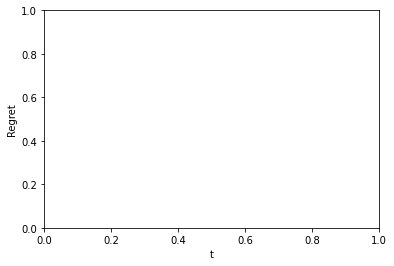

In [6]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - swts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'b')
plt.legend(["Greedy","TS","UCB","random"])
plt.show()

## TEST IF FUNCTION CORRECTLY WORKS (skip it)

In [7]:
n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 10

window_size = 100

swts_rewards_per_experiment = []
ucb_rewards_per_experiment = []

ts_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []

env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
ts_learner = TS_poisson(n_arms=n_arms)
swts_learner = SW_TS(n_arms, window_size)


pulled_arm = ts_learner.pull_arm(env.margins_matrix)
print(pulled_arm)
reward = env.round(pulled_arm)
#swts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)
swts_learner.t += 1
swts_learner.update_observations(pulled_arm, reward)

[0 0 0 0 0]


In [8]:
#print(swts_learner.beta_parameters)
print(env.daily_units)
print(env.purchases_current_day)
print(pulled_arm)

[10.  6. 15. 21.  3.]
[5. 6. 5. 7. 3.]
[0 0 0 0 0]


In [13]:
swts_learner.pulled_arms = [np.array([]) for j in range(5)]
swts_learner.clicks = [[[] for i in range(n_arms)] for j in range(5)]
swts_learner.purchases = [[[] for i in range(n_arms)] for j in range(5)]
swts_learner.n_bought_products =[[[] for i in range(n_arms)] for j in range(5)]
swts_learner.beta_parameters = np.array([np.ones((n_arms, 2))] * 5)
swts_learner.expected_rewards = np.zeros([5, n_arms])

'''
print(swts_learner.pulled_arms)
print(swts_learner.clicks)
print(swts_learner.purchases)
print(swts_learner.n_bought_products)
'''

#print(pulled_arm)
for i in range(5):
    swts_learner.pulled_arms[i] = np.append(swts_learner.pulled_arms[i], pulled_arm[i])
    for arm in range(n_arms):
        if arm == int(pulled_arm[i]):
            swts_learner.clicks[i][arm].append(env.clicks_current_day[i])
            swts_learner.purchases[i][arm].append(env.purchases_current_day[i])
            swts_learner.n_bought_products[i][arm].append(env.daily_units[i])
        else:
            swts_learner.clicks[i][arm].append(0)
            swts_learner.purchases[i][arm].append(0)
            swts_learner.n_bought_products[i][arm].append(0)

print('clicks: ',swts_learner.clicks)
print('purchases',swts_learner.purchases)
print('bought products',swts_learner.n_bought_products)

# cum_purchases = [[[0] for i in range(swts_learner.n_arms)] for j in range(5)]
# cum_clicks = [[[0] for i in range(swts_learner.n_arms)] for j in range(5)]
# n_bought_products = [[[0] for i in range(swts_learner.n_arms)] for j in range(5)]

purchase = env.purchases_current_day
click = env.clicks_current_day

for i in range(5):
    print('product',i)
    for arm in range(swts_learner.n_arms):
        n_samples = np.sum(swts_learner.pulled_arms[i][-swts_learner.window_size:] == arm)
        print('arm:',arm, ', n_samples:', n_samples)
        cum_purchases = np.sum(swts_learner.purchases[i][arm][-n_samples:])  if n_samples > 0 else 0
        cum_clicks = np.sum(swts_learner.clicks[i][arm][-n_samples:]) if n_samples > 0 else 0
        n_bought_products = np.sum(swts_learner.n_bought_products[i][arm][-n_samples:]) if n_samples > 0 else 0

        swts_learner.beta_parameters[i][arm, 0] = cum_purchases if n_samples > 0 else 1
        swts_learner.beta_parameters[i][arm, 1] = cum_clicks - cum_purchases if n_samples > 0 else 1

        print('cum_purchases: ',cum_purchases)
        print('cum_clicks',cum_clicks)
        print('beta_parameters',swts_learner.beta_parameters)


    #print('n_bought_products',n_bought_products)


to_continue=0
if to_continue:
    pulled_arm = ts_learner.pull_arm(env.margins_matrix)
    print(pulled_arm)
    reward = env.round(pulled_arm)
#swts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)
    swts_learner.t += 1
    swts_learner.update_observations(pulled_arm, reward)
    for i in range(5):
        swts_learner.pulled_arms[i] = np.append(swts_learner.pulled_arms[i], pulled_arm[i])
        for arm in range(n_arms):
            if arm == int(pulled_arm[i]):
                swts_learner.clicks[i][arm].append(env.clicks_current_day[i])
                swts_learner.purchases[i][arm].append(env.purchases_current_day[i])
                swts_learner.n_bought_products[i][arm].append(env.daily_units[i])
            else:
                swts_learner.clicks[i][arm].append(0)
                swts_learner.purchases[i][arm].append(0)
                swts_learner.n_bought_products[i][arm].append(0)


    print(swts_learner.clicks)
    print(swts_learner.purchases)
    print(swts_learner.n_bought_products)

'''


cum_purchases = [0 for j in range(5)]
cum_clicks = [0 for j in range(5)]
cum_bought_products = [0 for j in range(5)]

# print(cum_purchases)
# print(cum_clicks)
# print(cum_bought_products)

'''

clicks:  [[[0], [0], [0], [3.0]], [[0], [0], [3.0], [0]], [[0], [0], [0], [3.0]], [[0], [0], [0], [4.0]], [[0], [0], [0], [3.0]]]
purchases [[[0], [0], [0], [1.0]], [[0], [0], [1.0], [0]], [[0], [0], [0], [1.0]], [[0], [0], [0], [0.0]], [[0], [0], [0], [1.0]]]
bought products [[[0], [0], [0], [2.0]], [[0], [0], [1.0], [0]], [[0], [0], [0], [3.0]], [[0], [0], [0], [0.0]], [[0], [0], [0], [1.0]]]
product 0
arm: 0 , n_samples: 0
cum_purchases:  0
cum_clicks 0
beta_parameters [[[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]]
arm: 1 , n_samples: 0
cum_purchases:  0
cum_clicks 0
beta_parameters [[[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]]
arm: 2 , n_samples: 0
cum_purchase

'\n\n\ncum_purchases = [0 for j in range(5)]\ncum_clicks = [0 for j in range(5)]\ncum_bought_products = [0 for j in range(5)]\n\n# print(cum_purchases)\n# print(cum_clicks)\n# print(cum_bought_products)\n\n'

## SW-UCB

### Simulation in a static environment

In [14]:
#Comparison between SW-UCB and UCB

n_arms = 4
num_users = 100
n_days = 20
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 1

window_size = 10

sw_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

sw_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    sw_UCB_learner = SW_UCB(n_arms, window_size)

    for d in range(n_days):

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = sw_UCB_learner.pull_arm()
        reward = env.round(pulled_arm, )
        sw_UCB_learner.update(pulled_arm, reward)

    sw_ucb_rewards_per_experiment.append(sw_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    sw_ucb_pulls_per_arm_per_experiment.append(sw_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

-----------time  1
pulled  [0 0 0 0 0]
-----------time  2
pulled  [1 1 1 1 1]
-----------time  3
pulled  [2 2 2 2 2]
-----------time  4
pulled  [3 3 3 3 3]
-----------time  5
pulled  [0 0 0 0 0]
-----------time  6
pulled  [1 1 1 1 1]
-----------time  7
pulled  [2 2 2 2 2]
-----------time  8
pulled  [3 3 3 3 3]
-----------time  9
pulled  [3. 3. 1. 0. 0.]
-----------time  10
pulled  [3. 3. 1. 3. 0.]
-----------time  11
pulled  [2. 3. 0. 0. 0.]
-----------time  12
pulled  [1. 0. 0. 0. 0.]
-----------time  13
pulled  [1. 1. 0. 1. 0.]
-----------time  14
pulled  [2. 2. 2. 0. 0.]
-----------time  15
pulled  [3. 2. 2. 0. 0.]
-----------time  16
pulled  [0. 2. 2. 0. 0.]
-----------time  17
pulled  [0. 3. 0. 0. 1.]
-----------time  18
pulled  [1. 0. 0. 2. 1.]
-----------time  19
pulled  [2. 2. 3. 2. 2.]
-----------time  20
pulled  [2. 0. 3. 2. 3.]


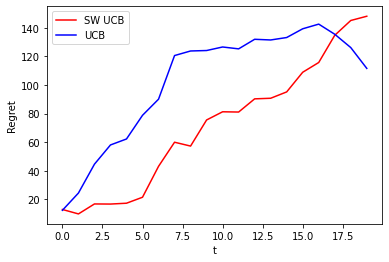

In [15]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - sw_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["SW UCB","UCB"])
plt.show()

Come previsto, SW UCB si comporta peggio di UCB (in un AMBIENTE STATICO).

## Simulation in a changing environment

In [21]:
#Comparison between SW-UCB and UCB

n_arms = 4
num_users = 100
n_days = 100
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 1

days_of_change = [50, 70]

window_size = 50

sw_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

sw_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    sw_UCB_learner = SW_UCB(n_arms, window_size)

    for d in range(n_days):
        for day_of_change in days_of_change:
            if d==day_of_change:
                env.abrupt_change([0],1.20)
        print(User0.avg_reservation_price)

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = sw_UCB_learner.pull_arm()
        reward = env.round(pulled_arm, )
        sw_UCB_learner.update(pulled_arm, reward)

    sw_ucb_rewards_per_experiment.append(sw_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    sw_ucb_pulls_per_arm_per_experiment.append(sw_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

[10 20 30 40 50]
-----------time  1
pulled  [0 0 0 0 0]
[10 20 30 40 50]
-----------time  2
pulled  [1 1 1 1 1]
[10 20 30 40 50]
-----------time  3
pulled  [2 2 2 2 2]
[10 20 30 40 50]
-----------time  4
pulled  [3 3 3 3 3]
[10 20 30 40 50]
-----------time  5
pulled  [0 0 0 0 0]
[10 20 30 40 50]
-----------time  6
pulled  [1 1 1 1 1]
[10 20 30 40 50]
-----------time  7
pulled  [2 2 2 2 2]
[10 20 30 40 50]
-----------time  8
pulled  [3 3 3 3 3]
[10 20 30 40 50]
-----------time  9
pulled  [2. 3. 1. 2. 0.]
[10 20 30 40 50]
-----------time  10
pulled  [2. 2. 1. 2. 0.]
[10 20 30 40 50]
-----------time  11
pulled  [2. 2. 1. 2. 0.]
[10 20 30 40 50]
-----------time  12
pulled  [3. 2. 1. 2. 0.]
[10 20 30 40 50]
-----------time  13
pulled  [1. 2. 1. 2. 0.]
[10 20 30 40 50]
-----------time  14
pulled  [1. 0. 1. 0. 0.]
[10 20 30 40 50]
-----------time  15
pulled  [3. 2. 1. 0. 0.]
[10 20 30 40 50]
-----------time  16
pulled  [2. 3. 2. 0. 0.]
[10 20 30 40 50]
-----------time  17
pulled  [3. 3. 2. 2.

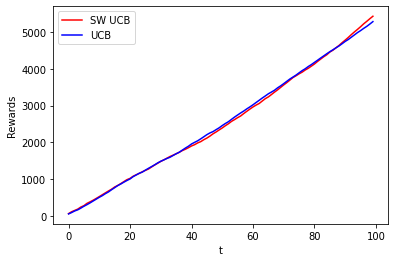

In [19]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Rewards")
plt.plot(np.cumsum(np.mean(sw_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["SW UCB","UCB"])
plt.show()

Questa volta SW-UCB si comporta meglio!

## SD1-UCB

In [ ]:
#Comparison between SD1-UCB and UCB
# static environment

n_arms = 4
num_users = 100
n_days = 20
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 1

window_size = 10

cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CD1_UCB(n_arms, window_size)
    reset_users_reserv_prices()
    print(User0.avg_reservation_price) #vorrei capire perché non va !!!!
    User0.reset_avg_reservation_price()
    print(User0.avg_reservation_price) #vorrei capire perché non va !!!!

    for d in range(n_days):

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        reward = env.round(pulled_arm, )
        cd_UCB_learner.update(pulled_arm, reward)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

In [ ]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - cd_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["CD1-UCB","UCB"])
plt.show()

In [ ]:
#Comparison between SD1-UCB and UCB
# dynamic environment

n_arms = 4
num_users = 100
n_days = 100
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 1

window_size = 50

days_of_change = [50, 70]


cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CD1_UCB(n_arms, window_size)

    for d in range(n_days):
        for day_of_change in days_of_change:
            if d==day_of_change:
                env.abrupt_change([0],1.20)

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        reward = env.round(pulled_arm, )
        cd_UCB_learner.update(pulled_arm, reward)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Rewards:")
plt.plot(np.cumsum(np.mean(cd_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["CD1-UCB","UCB"])
plt.show()

Usando il secondo algoritmo (CUSUM 2), quello del paper e dei ragazzi

In [ ]:
#Comparison between CU-SUM UCB and UCB
# static environment

n_arms = 4
num_users = 100
n_days = 20
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 1

window_size = 10

cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CUSUM_UCB(n_arms)

    for d in range(n_days):
        print('day ', d)
        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        print(pulled_arm)
        reward = env.round(pulled_arm, )
        cd_UCB_learner.update(pulled_arm, reward, env.purchases_current_day,env.clicks_current_day)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm,)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - cd_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["CUSUM-UCB", "UCB"])
plt.show()

In [ ]:
#Comparison between CUSUM-UCB and UCB
# dynamic environment

n_arms = 4
num_users = 100
n_days = 100
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 1

window_size = 50

days_of_change = [50, 70]


cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CUSUM_UCB(n_arms, window_size)

    for d in range(n_days):
        print('--------day--------', d)
        for day_of_change in days_of_change:
            if d==day_of_change:
                env.abrupt_change([0],1.20)

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        reward = env.round(pulled_arm)
        cd_UCB_learner.update(pulled_arm, reward, env.purchases_current_day,env.clicks_current_day)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Rewards:")
plt.plot(np.cumsum(np.mean(cd_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["CUSUM-UCB","UCB"])
plt.show()